In [19]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import imagecodecs

In [20]:
df = pd.read_csv("filled/transact_18_22.csv")
df.set_index(['client', 'date'], inplace=True)
df.index = df.index.set_levels(pd.to_datetime(df.index.levels[1]), level=1)
df = df.sort_index()
df

survival  socialization  self_realization  code
client  date                                                       
224     2019-01-03       1.0            0.0               0.0   1.0
        2019-01-04       0.0            0.0               0.0   0.0
        2019-01-05       1.0            0.0               0.0   1.0
        2019-01-06       1.0            1.0               0.0   3.0
        2019-01-07       1.0            0.0               0.0   1.0
...                      ...            ...               ...   ...
3564569 2019-12-10       1.0            0.0               0.0   1.0
        2019-12-11       1.0            0.0               0.0   1.0
        2019-12-12       1.0            0.0               0.0   1.0
        2019-12-13       1.0            0.0               0.0   1.0
        2019-12-14       1.0            0.0               0.0   1.0

[2760863 rows x 4 columns]

In [21]:
def compute_lzw_ratios_lib2(df: pd.DataFrame, columns: list):
    clients = df.index.get_level_values(0).unique()
    results = []

    for client in tqdm(clients, desc="Processing clients"):
        client_data = df.xs(client, level=0)
        row = {}

        for col in columns:
            seq = client_data[col].astype(str).tolist()
            data_bytes = ''.join(seq).encode('utf-8')

            compressed_bytes = imagecodecs.lzw_encode(data_bytes)

            original_size = len(data_bytes) * 8
            compressed_size = len(compressed_bytes) * 8
            ratio = compressed_size / original_size

            row[f'lzw_ratio_{col}'] = ratio

        results.append(pd.Series(row, name=client))

    df_result = pd.DataFrame(results)
    df_result.index.name = "client"
    return df_result

In [22]:
lzw_df = compute_lzw_ratios_lib2(df, ["code"])
lzw_df

Processing clients: 100%|██████████| 8034/8034 [00:03<00:00, 2513.15it/s]


,lzw_ratio_code
client,
224,0.202312
1117,0.175845
1197,0.193237
1223,0.184645
1555,0.201729
...,...
3560436,0.189774
3561841,0.198459
3561945,0.172947


In [23]:
def plot_lzw_distributions(df_lzw):
    num_cols = len(df_lzw.columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(8, 4*num_cols))
    if num_cols == 1:
        axes = [axes]

    for ax, col in zip(axes, df_lzw.columns):
        sns.histplot(df_lzw[col], bins=10, kde=True, ax=ax, color='salmon')
        ax.set_title(f'Distribution of {col}', fontsize=14)
        ax.set_xlabel('LZW Compression Ratio')
        ax.set_ylabel('Clients')
        ax.set_xlim(0, max(df_lzw[col].max()*1.1, 1.0))

    plt.tight_layout()
    plt.show()

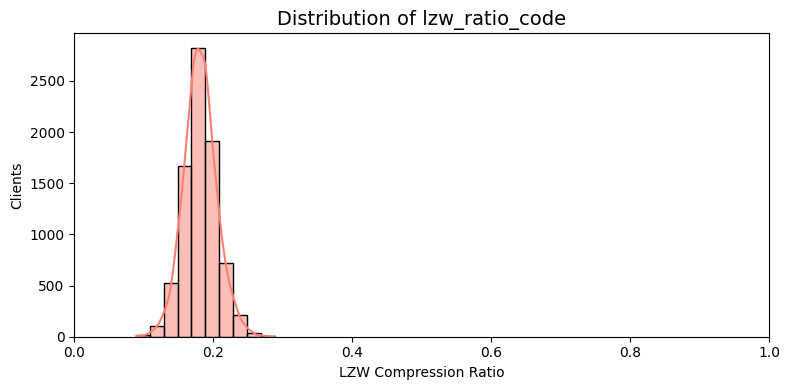

In [24]:
plot_lzw_distributions(lzw_df)